In [2]:
import numpy as np
import os, sys
import yaml
import astropy.io.ascii as ascii
%pylab inline
from astropy.io import fits
from astropy.table import Table,join
import astropy as ap
from multiprocessing import Pool,Value
from functools import partial
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy import ndimage
from matplotlib.patches import Ellipse, Circle

Populating the interactive namespace from numpy and matplotlib


In [10]:
def rebin(a, *args):
    # rebins a 3D array to a new shape
    shape = a.shape
    lenShape = len(shape)
    factor = (np.asarray(shape)/np.asarray(args)).astype(int)
    evList = ['a.reshape('] + \
             ['args[%d],factor[%d],'%(i,i) for i in range(lenShape)] + \
             [')'] + ['.mean(%d)'%(i+1) for i in range(lenShape)]
    return eval(''.join(evList))

In [40]:
source_id = np.loadtxt('source_id.txt',dtype=str)
z_table = []
z_2d = []
z_2d_up1 = []
z_2d_low1 = []
for id_name in source_id:
    z = Table.read('output_10pix_nosm/ELD_oh12_2d_id%s.txt'%id_name,format='ascii.commented_header')
    z_table.append(z)
    z_2d.append(z['me'].copy().reshape(20,20))
    z_2d_up1.append(z['me_up1sig'].copy().reshape(20,20))
    z_2d_low1.append(z['me_low1sig'].copy().reshape(20,20))

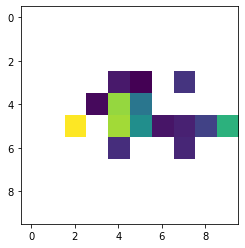

In [39]:
imshow(z_2d[2])

In [18]:
ra = np.array([])
dec = np.array([])
for i in source_id:
    info = Table.read('../grismspec_boss1244_210627/boss1244_DR210308_%s.row.fits'%i,hdu=1)
    ra = np.append(ra,asarray(info['ra']))
    dec = np.append(dec,asarray(info['dec']))

In [19]:
w = 10

j1244_cut = fits.open('../Photometry/j1244_cut.fits')
j1244_cut_img = j1244_cut[0].data
j1244_cut.close()

h1244_cut = fits.open('../Photometry/h1244_cut.fits')
h1244_cut_img = h1244_cut[0].data
h1244_cut.close()

w_j_cut = WCS(j1244_cut[0].header)
j1244_cut.close()

c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree)

j_x = w_j_cut.world_to_pixel(c)[0]
j_y = w_j_cut.world_to_pixel(c)[1]

h1244_wht = fits.open('../Photometry/h1244_wht_cut.fits')
h1244_wht_img = h1244_wht[0].data

seg_all = fits.open('/home/zihao/win/study/astrophysics/sextractor-2.25.0/tests/h1244/h1244.seg.fits')
seg_all = seg_all[0].data

s_pix = w
# j_stamp = []
h_stamp = []
h_wht_stamp = []
seg_stamp = []
for i in range(len(source_id)):

    j_cutx = round(j_x[i])
    j_cuty = round(j_y[i])
#     j_stamp.append(j1244_cut_img[j_cuty-s_pix:j_cuty+s_pix,j_cutx-s_pix:j_cutx+s_pix])
    h_stamp.append(h1244_cut_img[j_cuty-s_pix:j_cuty+s_pix,j_cutx-s_pix:j_cutx+s_pix])
    h_wht_stamp.append(h1244_wht_img[j_cuty-s_pix:j_cuty+s_pix,j_cutx-s_pix:j_cutx+s_pix])
    seg_stamp.append(seg_all[j_cuty-s_pix:j_cuty+s_pix,j_cutx-s_pix:j_cutx+s_pix])

In [26]:
EL_data = []
for j,i in enumerate(source_id):

    info = Table.read('../grismspec_boss1244_210627/boss1244_DR210308_%s.row.fits'%i,hdu=1)
    ra1 = info['ra']
    dec1 = info['dec']
#     z = info['redshift']
#     g141 = info['t_g141']
    hdu = fits.open('../grismspec_boss1244_210627/boss1244_DR210308_%s.full.fits'%i)
    sp_1d = Table.read('../grismspec_boss1244_210627/boss1244_DR210308_%s.1D.fits'%i,hdu=1)
    wave_1d = sp_1d['wave']
    flat = sp_1d['flat']
    Elines = {}
    
#     seg = hdu[4].data[66-w:66+w,66-w:66+w].astype(float)
    seg = seg_stamp[j].astype(float)
    seg[seg!=seg[w,w]] = nan
    seg/=seg[w,w]
    for j in range(len(hdu)):
        try:
            header = hdu[j].header
            EXTVER = header['EXTVER']
            EXTNAME = header['EXTNAME']
            if EXTVER in ['OII','Hg','Hb','OIII'] and EXTNAME =='LINE':
#                 flat_idx = np.argmin(np.abs(wave_1d - hdu[j].header['WAVELEN']))              
#                 Elines['flux_'+EXTVER] = (seg*ndimage.gaussian_filter(hdu[j].data[66-w:66+w,66-w:66+w],3.33/2.335))
#                 Elines['flux_'+EXTVER] = (seg*ndimage.median_filter(hdu[j].data[66-w:66+w,66-w:66+w],3))
                Elines['flux_'+EXTVER] = seg*hdu[j].data[66-w:66+w,66-w:66+w]

            elif EXTVER in ['OII','Hg','Hb','OIII'] and EXTNAME =='LINEWHT':
#                 flat_idx = np.argmin(np.abs(wave_1d - hdu[j].header['WAVELEN']))
#                 Elines['err_'+EXTVER] = (seg/ndimage.gaussian_filter(hdu[j].data[66-w:66+w,66-w:66+w],3.33/2.335))
#                 Elines['err_'+EXTVER] = (seg/ndimage.median_filter(hdu[j].data[66-w:66+w,66-w:66+w],3))
                Elines['err_'+EXTVER] = seg/hdu[j].data[66-w:66+w,66-w:66+w]
        except:
            continue
    dat_ELflux = Table(Elines)
#     dat_ELflux.add_column(g141,index=0)
#     dat_ELflux.add_column(z,index=0)
    dat_ELflux.add_column(col=dec1,index=0)
    dat_ELflux.add_column(col=ra1,index=0)
    dat_ELflux.add_column(name='id',col=i,index=0)
    sci_img = hdu[5].data[66-w:66+w,66-w:66+w]*seg
    hdu.close()
#     dat_ELflux['flux_OIII'] *= 3./4.
#     dat_ELflux['err_OIII'] *= 3./4.
    
    #------------ change the unit of line flux/err to 1e-19
    linelist = [x.split('_')[-1] for x in dat_ELflux.colnames if 'flux_' in x]
#     for line in linelist:
#         dat_ELflux['flux_'+line] /= 1.e-19
#         dat_ELflux['err_'+line] /= 1.e-19
    EL_data.append(dat_ELflux)

In [7]:
# for i in range(len(source_id)):
#     hdu = fits.PrimaryHDU(data=h_stamp[i])
#     hdu.writeto('galfit/h_stamp_10pix/h1244_s%s.fits'%source_id[i],overwrite=True)
    
#     hdu = fits.PrimaryHDU(data=h_wht_stamp[i])
#     hdu.writeto('galfit/h_stamp_10pix/h1244_wht_s%s.fits'%source_id[i],overwrite=True)

In [22]:
fitnumber = ['0'*(2-len(str(i)))+str(i) for i in np.arange(len(z_2d))+1]

galfit = []
for i,n in enumerate(source_id):
    file = open("galfit/galfit_output_10pix/galfit_%s.txt"%n, "r")
    name = file.readlines()
    x = float(name[40][4:11])
    y = float(name[40][13:20])
    R_e = float(name[42][4:11])
    ab = float(name[47][4:11])
    angle = float(name[48][4:11])
    
    a = R_e/ab**0.5
    b = R_e*ab**0.5
    
    galfit.append(np.array([x,y,a,b,angle]))

In [47]:
# rebinned
# galfit = []
# for i,n in enumerate(source_id):
#     file = open("galfit/galfit_output_10pix/galfit_%s.txt"%n, "r")
#     name = file.readlines()
#     x = float(name[40][4:11])/2
#     y = float(name[40][13:20])/2
#     R_e = float(name[42][4:11])/2
#     ab = float(name[47][4:11])
#     angle = float(name[48][4:11])
    
#     a = R_e/ab**0.5
#     b = R_e*ab**0.5
    
#     galfit.append(np.array([x,y,a,b,angle]))

In [185]:
where(source_id=='02330')

(array([22]),)

In [15]:
flux_OIII.shape

(40, 40)

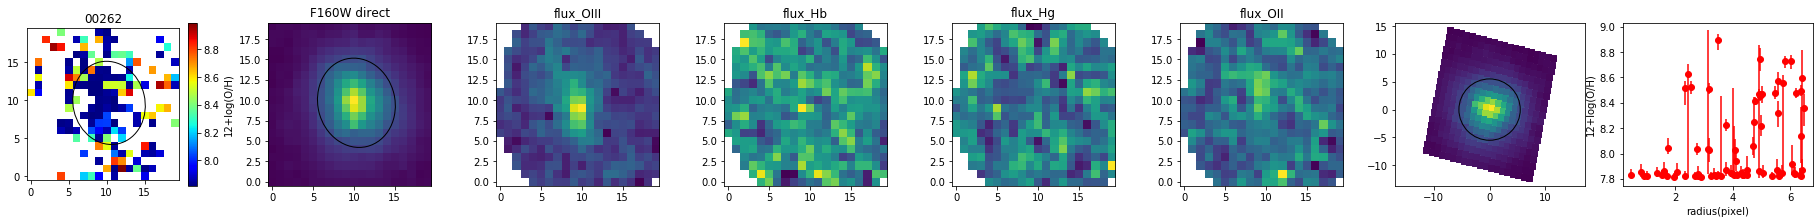

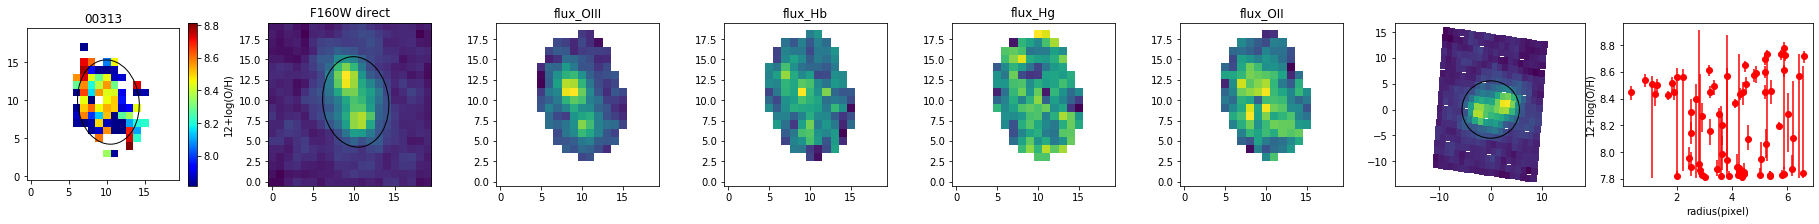

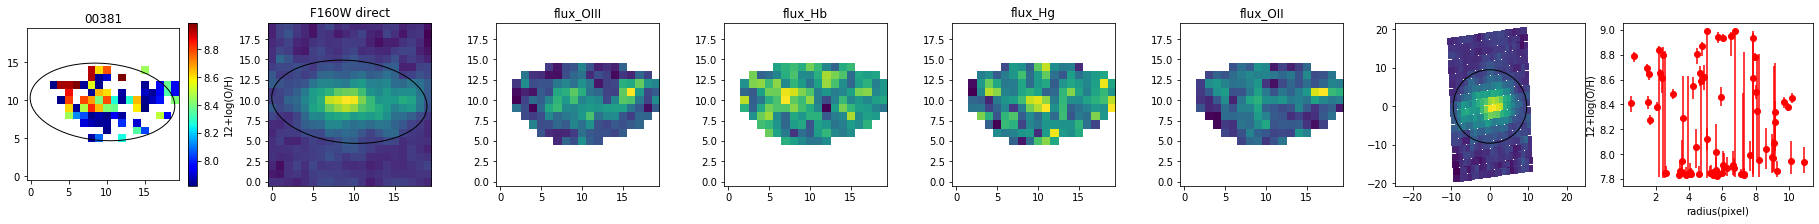

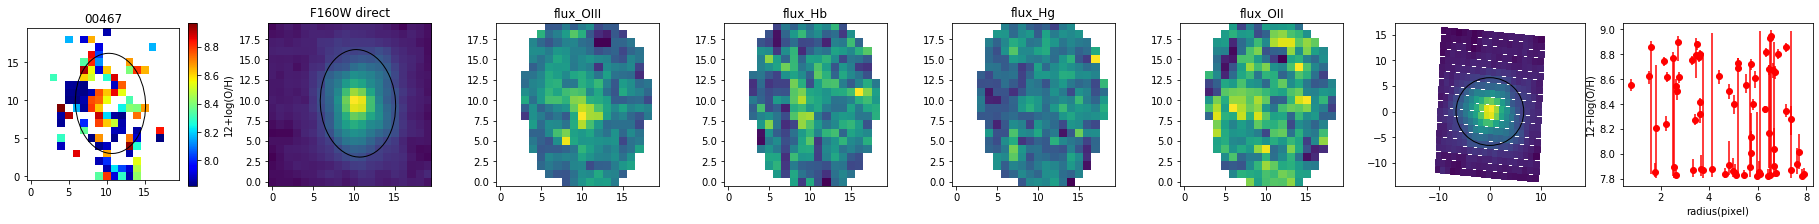

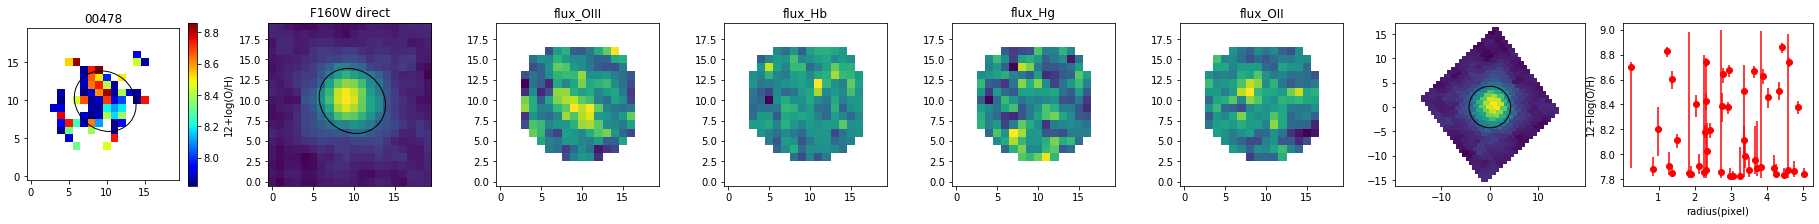

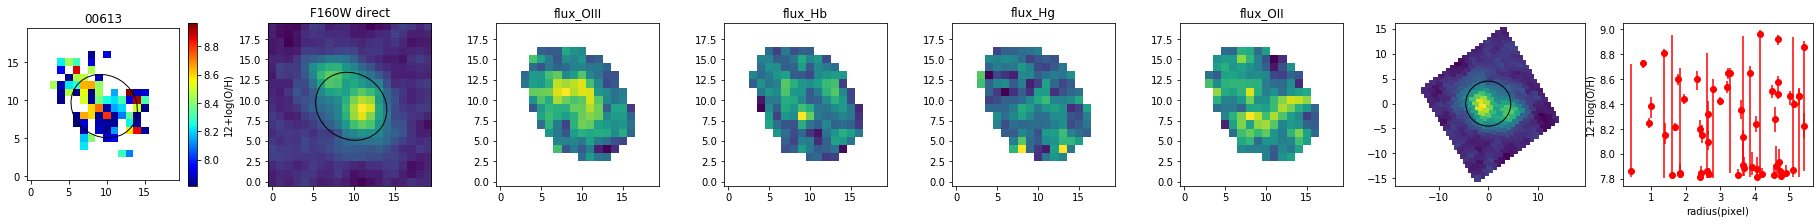

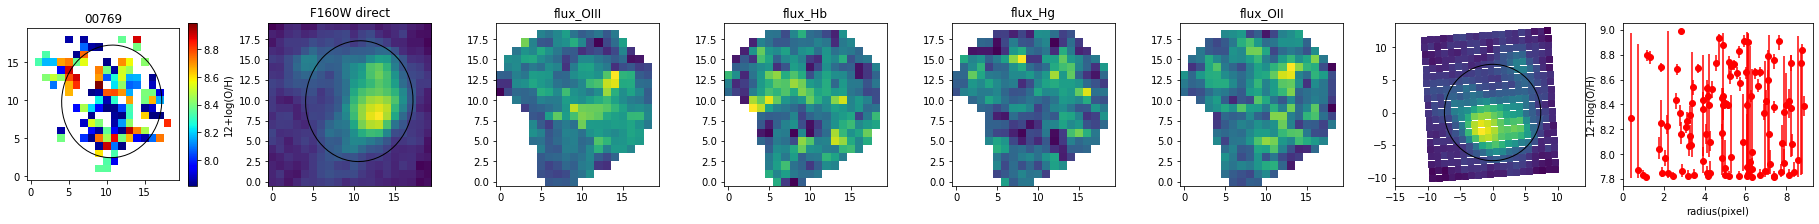

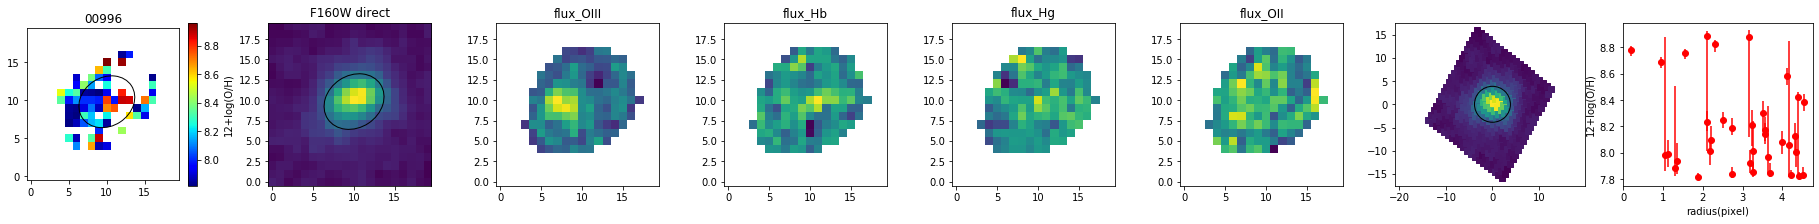

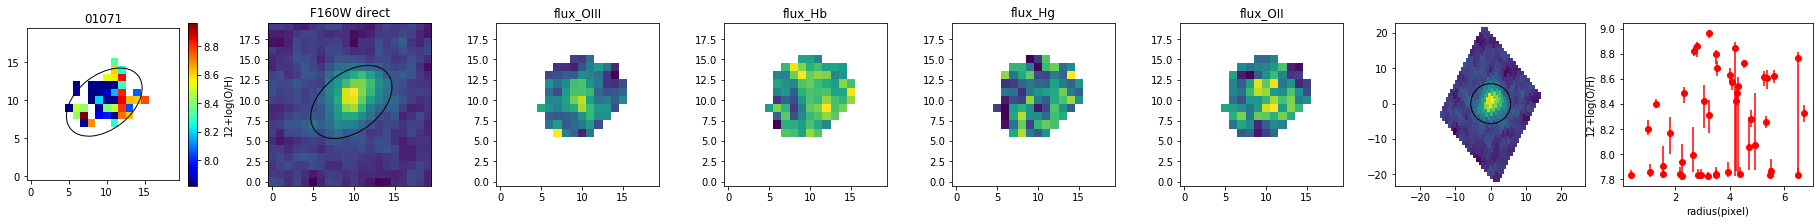

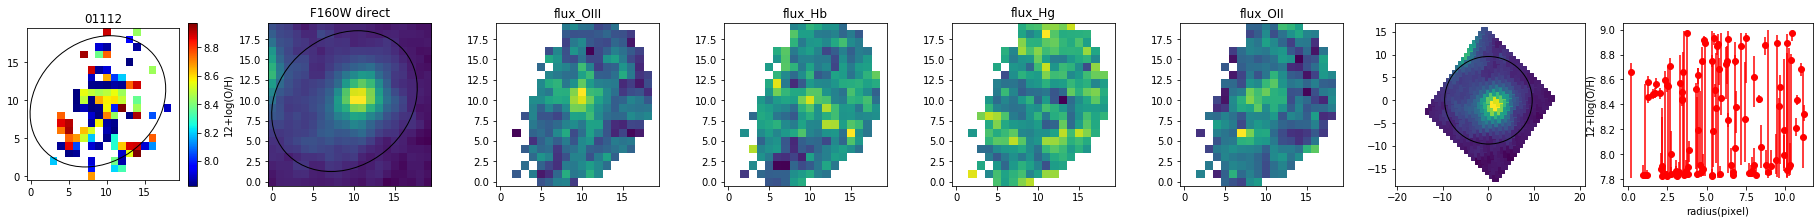

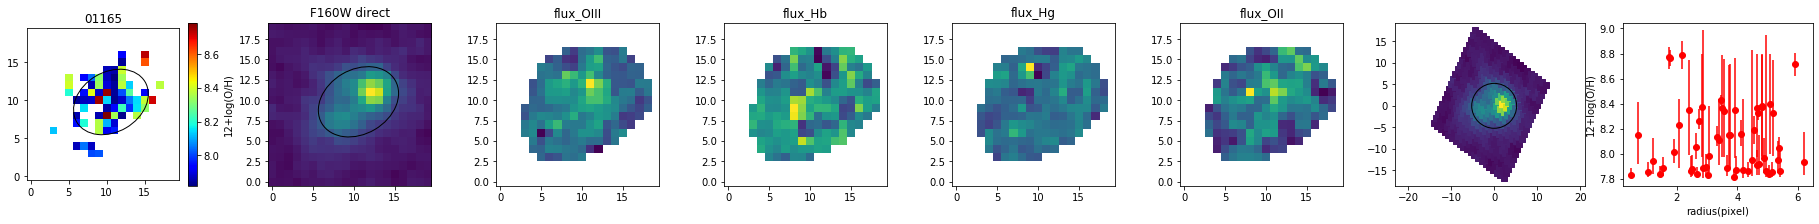

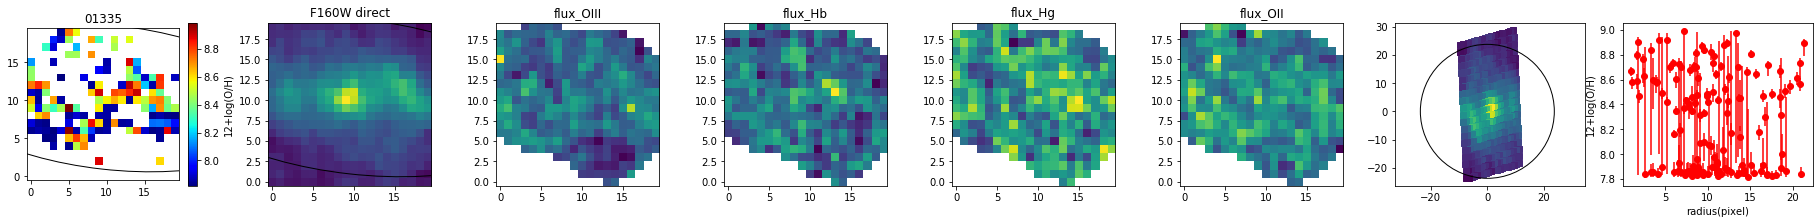

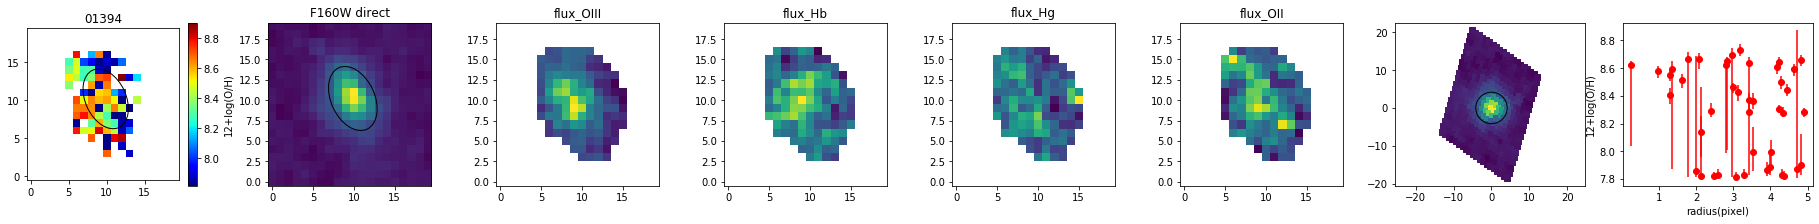

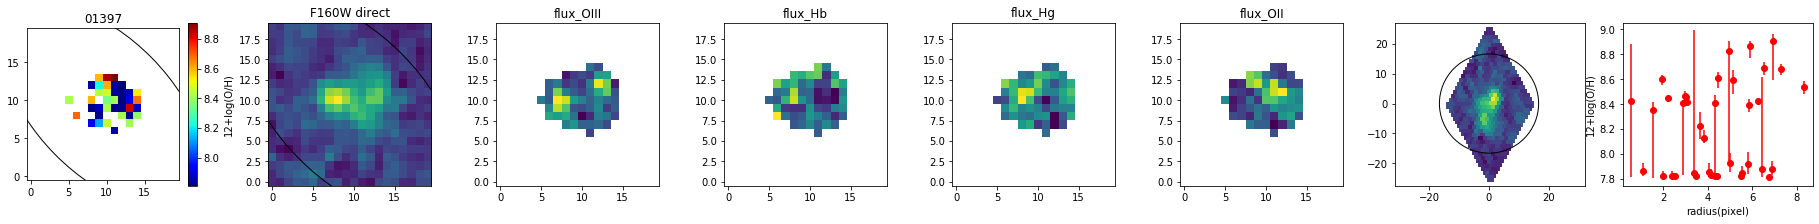

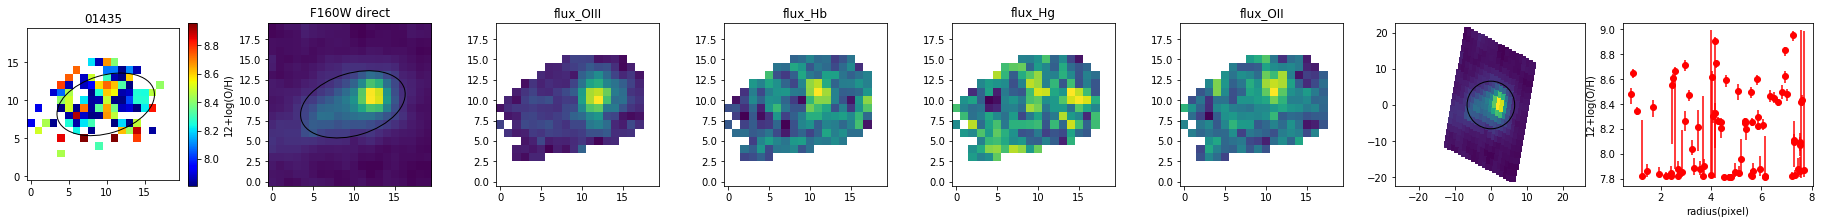

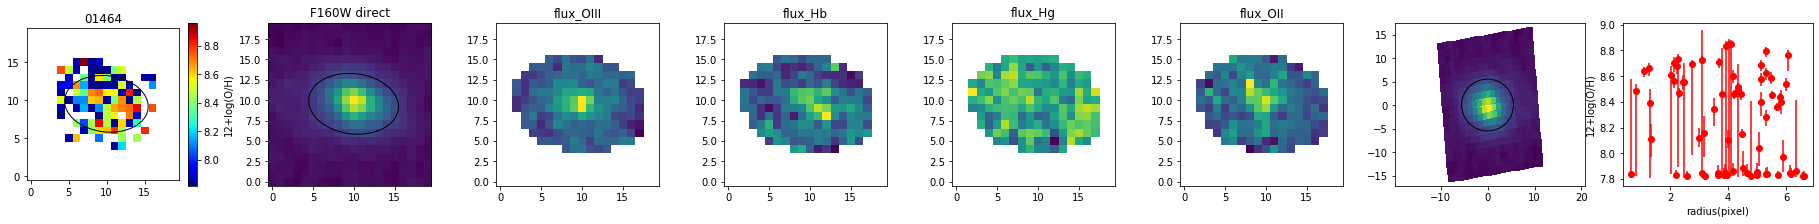

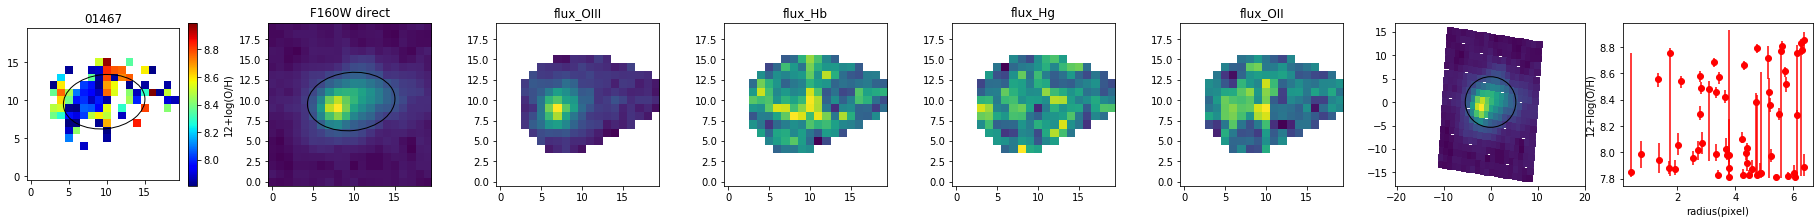

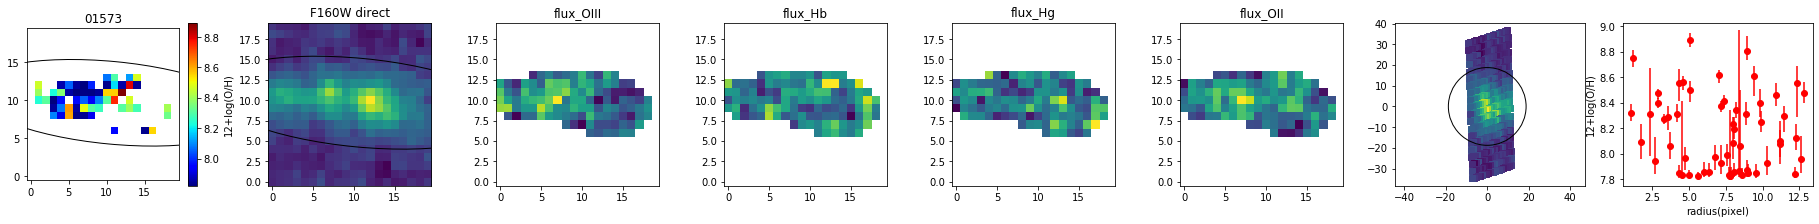

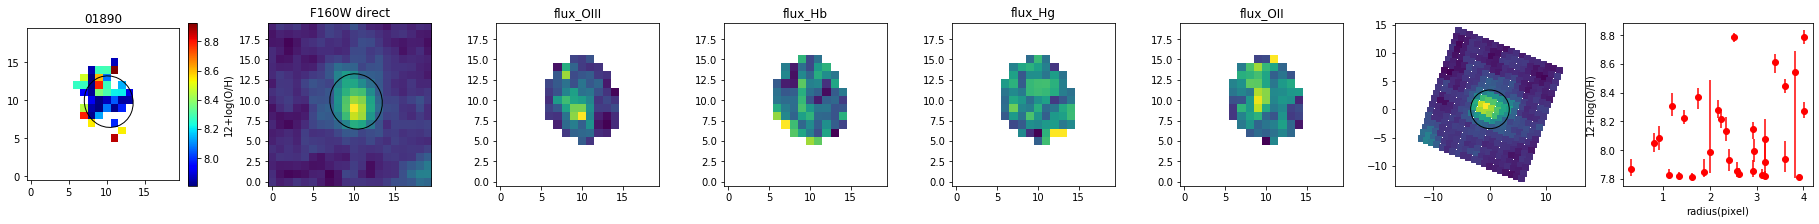

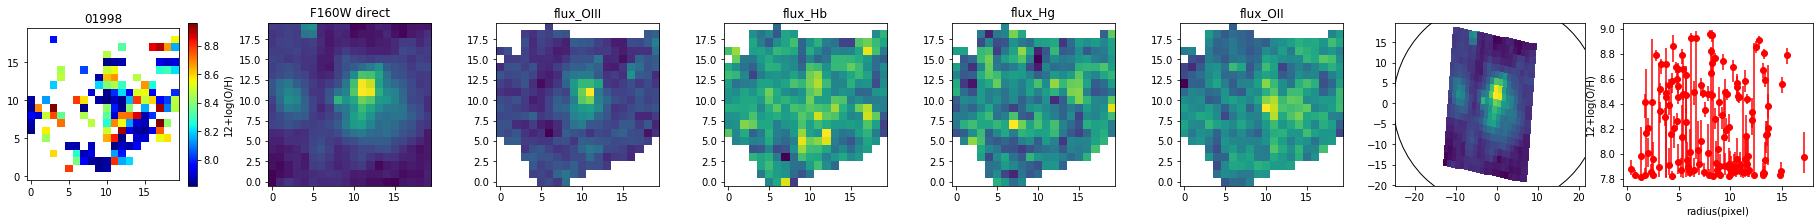

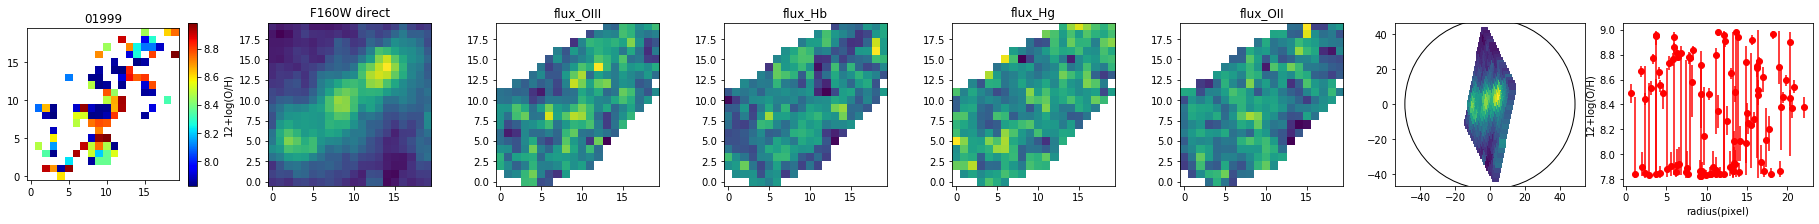

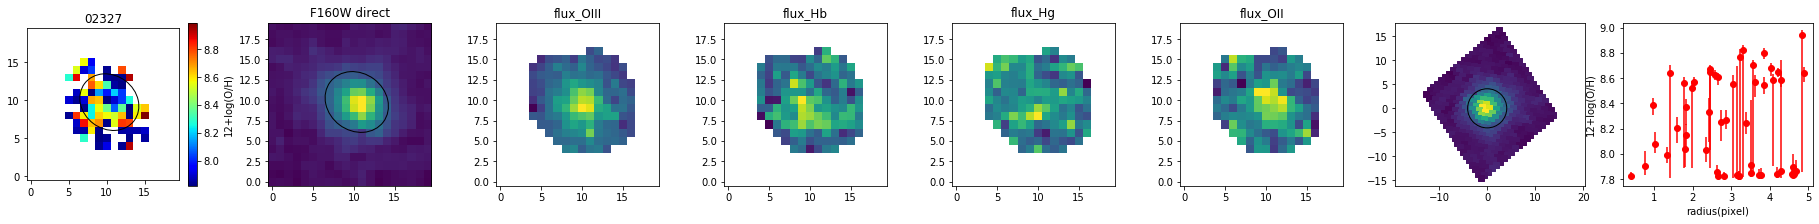

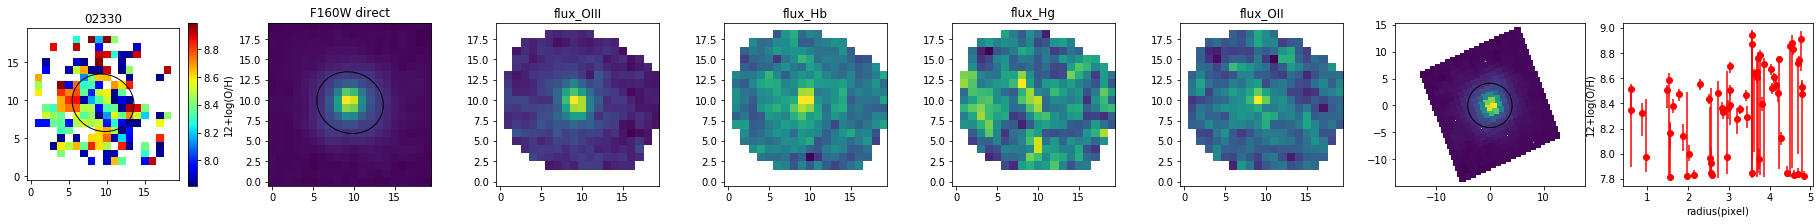

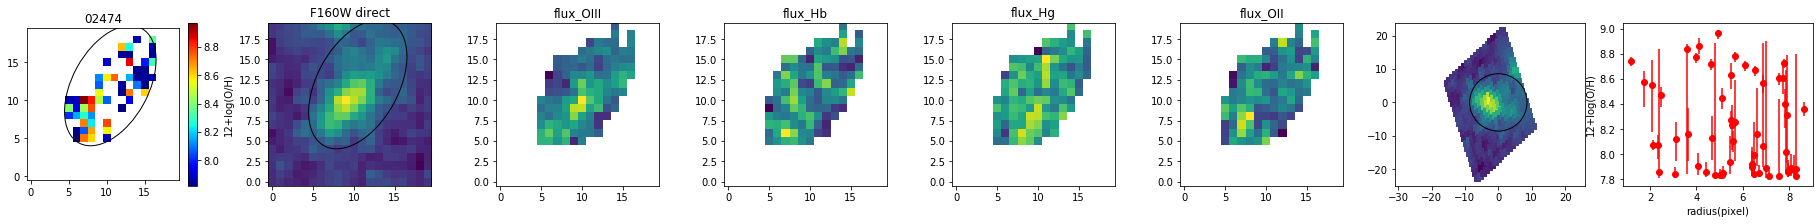

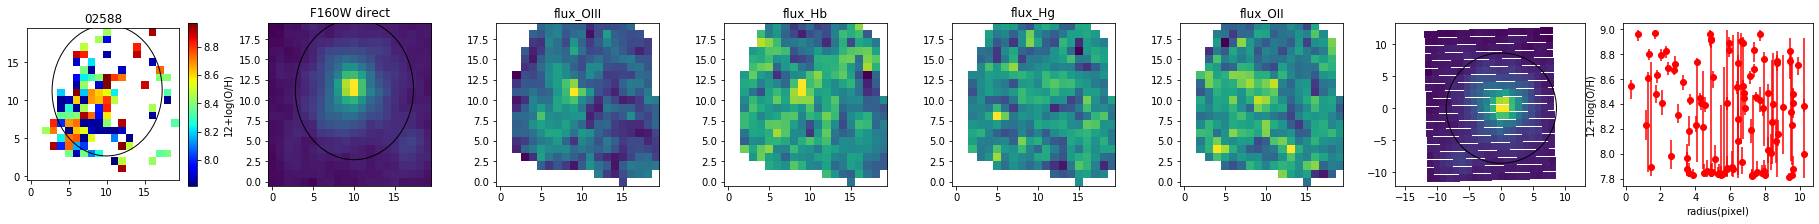

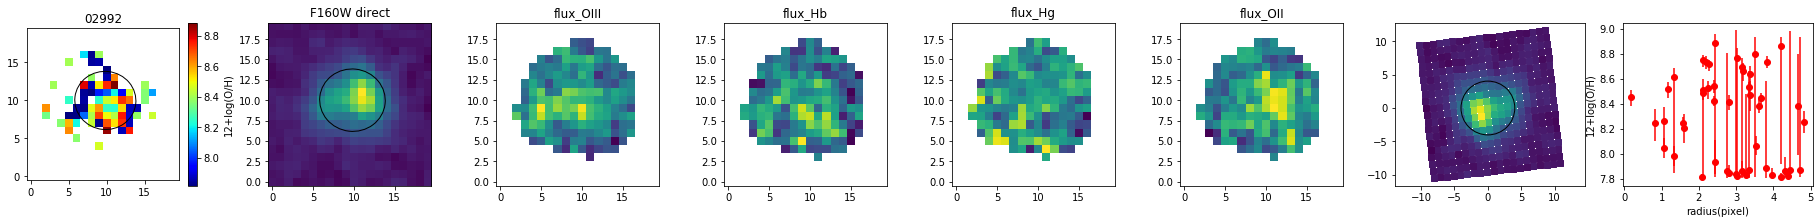

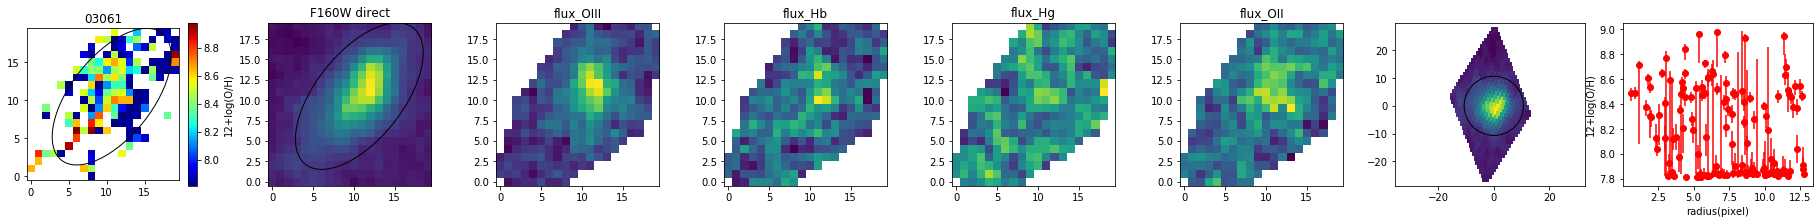

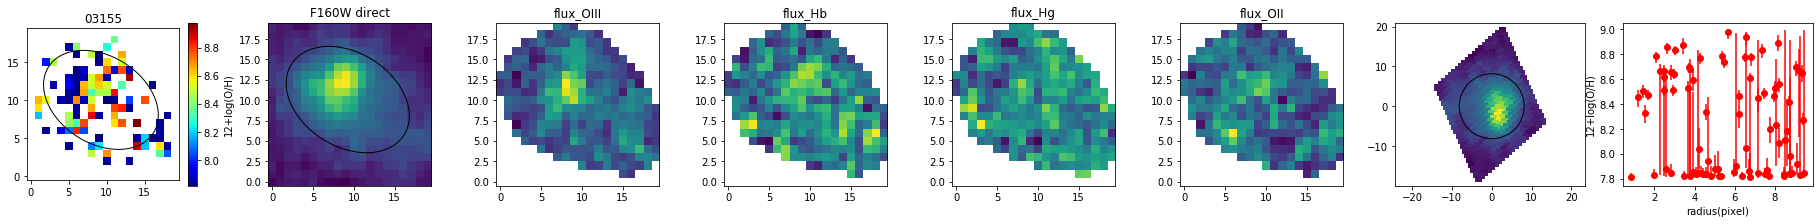

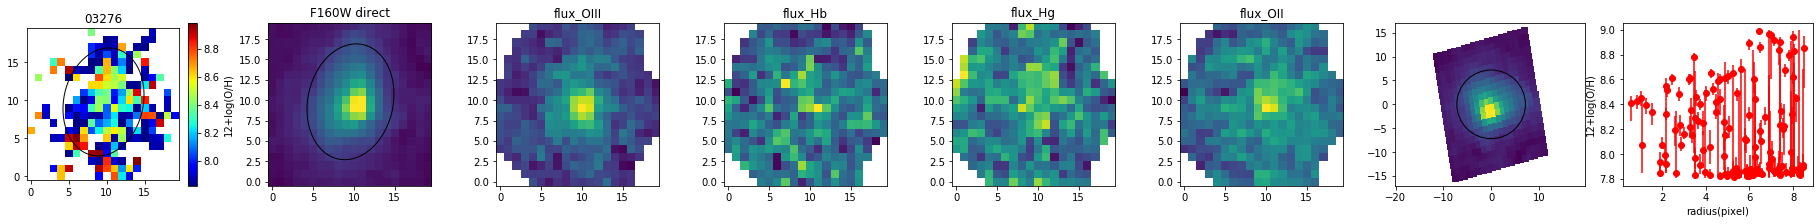

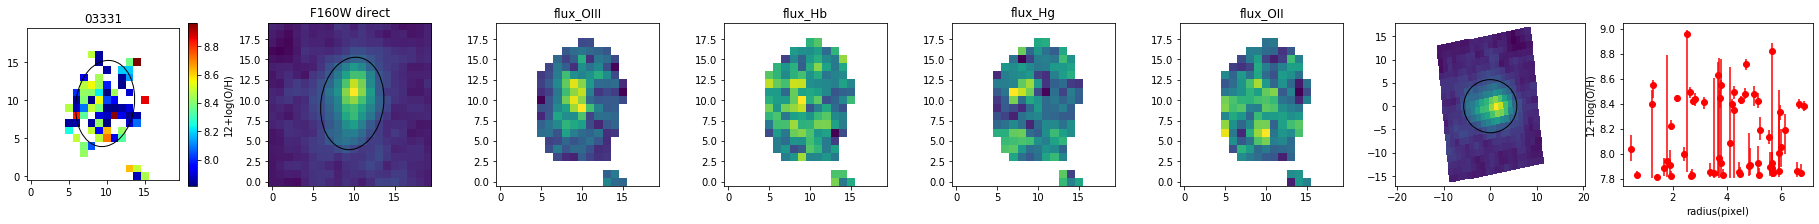

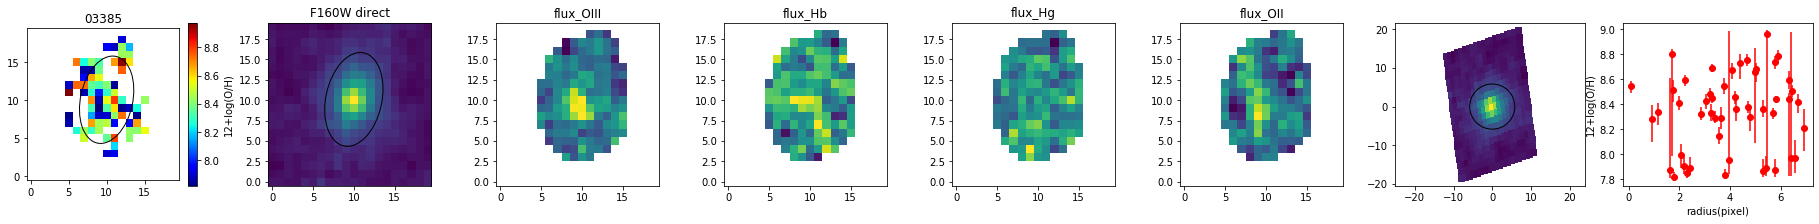

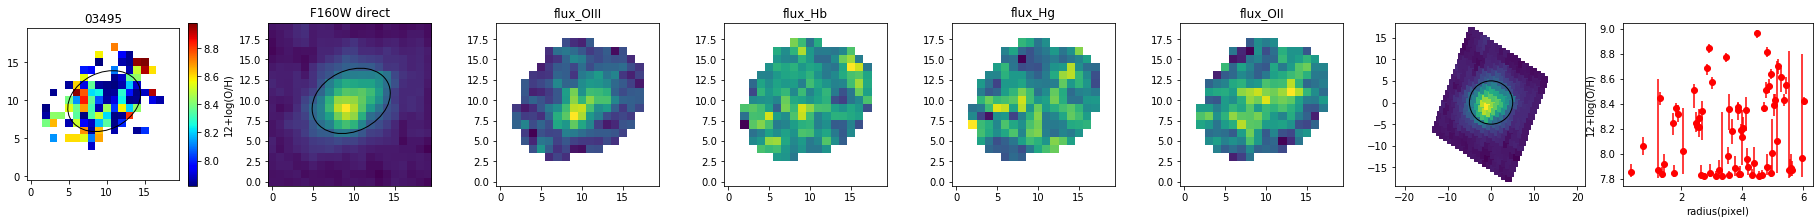

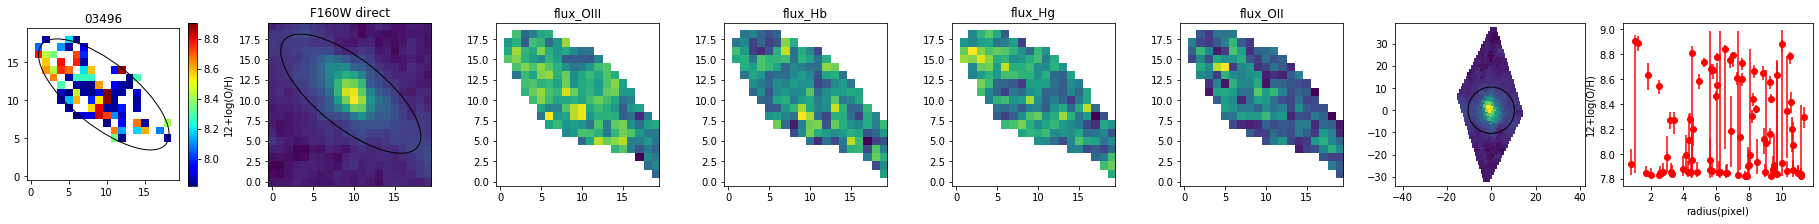

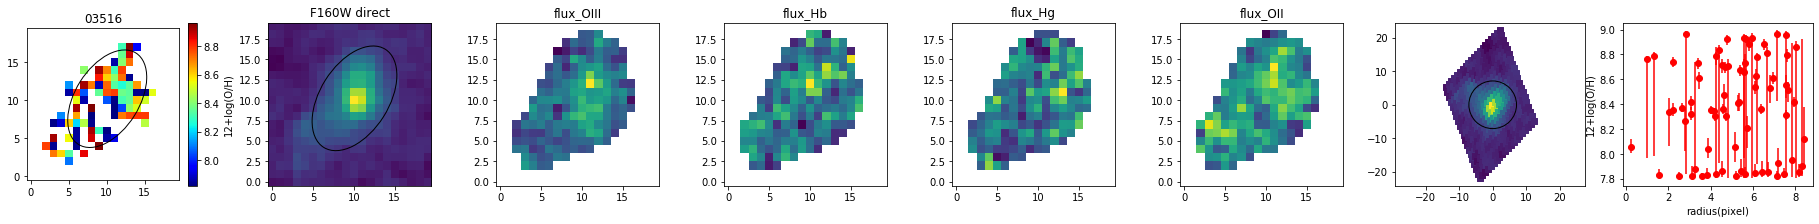

In [64]:
EL = ['flux_OIII','flux_Hb','flux_Hg','flux_OII']

for i in range(len(z_2d)):
# for i in [22]:
    tresh = 2
#     flux_OIII = rebin(EL_data[i]['flux_OIII'],10,10)
#     err_OIII = rebin(EL_data[i]['err_OIII'],10,10)
#     flux_OII = rebin(EL_data[i]['flux_OII'],10,10)
#     err_OII = rebin(EL_data[i]['err_OII'],10,10)

    flux_OIII = EL_data[i]['flux_OIII']
    err_OIII = EL_data[i]['err_OIII']
    flux_OII = EL_data[i]['flux_OII']
    err_OII = EL_data[i]['err_OII']
#     flux_Hg = EL_data[i]['flux_Hg']
#     err_Hg = EL_data[i]['err_Hg']
#     flux_Hb = EL_data[i]['flux_Hb']
#     err_Hb = EL_data[i]['err_Hb']
    z_sn_crop = where((flux_OIII/err_OIII>tresh)&(flux_OII/err_OII>tresh),z_2d[i],np.nan)

    seg = seg_stamp[i].astype(float)
    seg[seg!=seg[w,w]] = nan
    seg/=seg[w,w]
    
    fig,ax = subplots(1,8,figsize=(32,3))
    tresh = 2

    im1 = ax[0].imshow(z_sn_crop,cmap='jet',origin='lower')
    ax[0].set_title(source_id[i])
    plt.colorbar(im1,ax=ax[0],label='12+log(O/H)')
    
    ax[1].imshow(h_stamp[i],origin='lower')
    ax[1].set_title('F160W direct')
    for j,a in enumerate(ax[2:-2]):
        a.imshow(asarray(EL_data[i][EL[j]]),origin='lower')
        a.set_title(EL[j])
#         a.set_yticks([])
    
    ell1 = Ellipse(xy = (galfit[i][:2]-1), width = 2*galfit[i][2], height = 2*galfit[i][3], angle = 90+galfit[i][4], ec= 'k',fill=False, alpha=1.0)
    ax[1].add_artist(ell1)
    
    
    x,y = np.meshgrid(linspace(1,20,20),linspace(1,20,20))
#     x,y = np.meshgrid(linspace(1,10,10),linspace(1,10,10))

    x -= galfit[i][0]
    y -= galfit[i][1]
    coord = np.array([x.flatten(),y.flatten()])

    angle = -(90+galfit[i][4])*2*np.pi/360

    ab = galfit[i][3]/galfit[i][2]
    # ab=1
    trans1 = np.array([[np.cos(angle),-np.sin(angle)],[np.sin(angle),np.cos(angle)]])
    trans2 = np.array([[1,0],[0,1/ab]])
    mat_trans = trans2@trans1
    
    x,y=mat_trans@coord
    d = (x**2+y**2)**0.5
    idx = where(d<1.2*galfit[i][2])
    ax[-2].scatter(x,y,marker='s',c=h_stamp[i].flatten())
    ax[-2].axis('equal')
    
    circ = Circle(xy = (0,0), radius = galfit[i][2], ec= 'k',fill=False, alpha=1.0)
    ax[-2].add_artist(circ)
    ell1 = Ellipse(xy = (galfit[i][:2]-1), width = 2*galfit[i][2], height = 2*galfit[i][3], angle = 90+galfit[i][4], ec= 'k',fill=False, alpha=1.0)
    ax[0].add_artist(ell1)
    

#     ax[-1].scatter(d[idx],z_2d[i].flatten()[idx])
    ax[-1].errorbar(d[idx],z_2d[i].flatten()[idx],yerr=((z_2d[i]-z_2d_low1[i]).flatten()[idx],(z_2d_up1[i]-z_2d[i]).flatten()[idx]),fmt='o',ecolor='r',color='r',elinewidth=0,capsize=0)
#     ax[-1].scatter(d,z_2d[i].flatten())
    ax[-1].set_xlabel('radius(pixel)')
    ax[-1].set_ylabel('12+log(O/H)')

    plt.show()


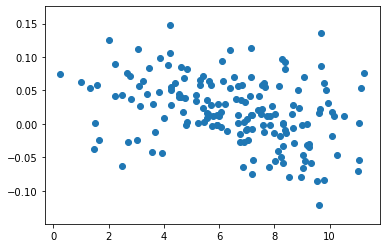

In [31]:
scatter(d,(flux_OII*seg).flatten())

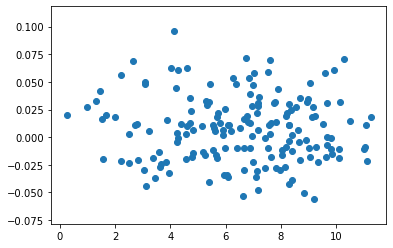

In [32]:
scatter(d,(flux_Hg*seg).flatten())

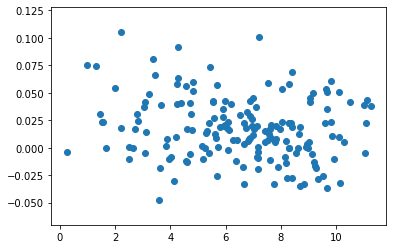

In [33]:
scatter(d,(flux_Hb*seg).flatten())

In [275]:
source_id[i]

'03516'

In [273]:
i

33

In [29]:
# i=22
flux_OIII = EL_data[i]['flux_OIII']
err_OIII = EL_data[i]['err_OIII']
flux_OII = EL_data[i]['flux_OII']
err_OII = EL_data[i]['err_OII']
flux_Hg = EL_data[i]['flux_Hg']
err_Hg = EL_data[i]['err_Hg']
flux_Hb = EL_data[i]['flux_Hb']
err_Hb = EL_data[i]['err_Hb']

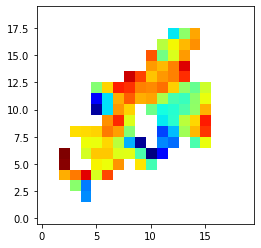

In [278]:
z_array = np.asarray(z_2d[i])
tresh = 2
# z_array = where((flux_OIII/err_OIII>tresh)&(flux_OII/err_OII>tresh)&(flux_Hg/err_Hg>tresh)&(flux_Hb/err_OIII>tresh),z_array,np.nan)
z_array = where((flux_OIII/err_OIII>tresh)&(flux_OII/err_OII>tresh),z_array,np.nan)

imshow(z_array,origin='lower',cmap='jet')

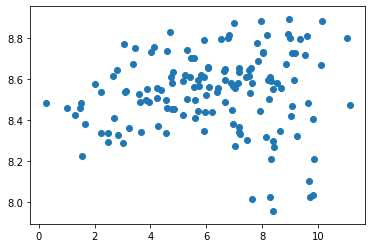

In [258]:
scatter(d,z_array.flatten())

In [ ]:
flux_sn = where(flux/err>2,flux,np.nan)

In [12]:
2/0.6/2.335

1.4275517487508924